In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

## Loading the IMDB dataset
The IMDB dataset is a set of $50,000$ highly polarized reviews from the **Internet Movie Database**.

They’re split into $25,000$ reviews for training and $25,000$ reviews for testing, each set consisting of 50% negative and 50% positive reviews.

The IMDB dataset comes packaged with Keras and it has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

In [2]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The argument ```num_words=10000``` means you’ll only keep the top $10,000$ most frequently occurring words in the training data. Rare words will be discarded.

This allows us to work with vector data of manageable size. If we didn’t set this limit, we’d be working with **$88,585$** unique words in the training data, which is unnecessarily large. Many of these words only occur in a single sample, and thus can’t be meaningfully used for
classification.

The variables ```train_data``` and ```test_data``` are lists of reviews; each review is a list of word indices (encoding a sequence of words).

```train_labels``` and ```test_labels``` are lists of $0s$ and $1s$, where $0$ stands for negative and $1$ stands for positive.

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

np.int64(1)

Of course, because we’re restricting ourselves to the top $10,000$ most frequent words, no word index will exceed $10,000$:

In [5]:
max([max(sequence) for sequence in train_data])

9999

## Preparing the data
You can’t directly feed lists of integers into a neural network. They all have different
lengths, but a neural network expects to process contiguous batches of data. You have
to turn your lists into tensors.

There are two ways to do that:
- **Pad your lists** so that they all have the same length, **turn them into an integer tensor** of shape ```(samples, max_length)```, and start your model with a layer capable of handling such integer tensors (_the Embedding layer_).
- **Multi-hot encode** your lists to turn them into vectors of $0$s and $1$s. This would mean, for instance, turning the sequence $[8, 5]$ into a $10,000$-dimensional vector that would be all $0$s except for indices $8$ and $5$, which would be $1s$. Then you could use a Dense layer, capable of handling floating-point vector data, as the first layer in your model.

### Encoding the integer sequences via multi-hot encoding

In [6]:
def vectorize_sequences(sequences, dimension=10000):
    # Creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.  # Sets specific indices to 1s
    return results

x_train = vectorize_sequences(train_data)  # Vectorized training data
x_test = vectorize_sequences(test_data)  # Vectorized test data

In [7]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [8]:
# Labels vectorization
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## Building the model
The input data is vectors, and the labels are scalars ($1s$ and $0s$): this is one of the simplest problem setups.

A type of model that performs well on such a problem is a plain stack of densely connected (Dense) layers with ReLU activations.

Our model will have:
- Two intermediate layers with 16 units each;
- A third layer that will output the scalar prediction regarding the sentiment of the current review.

<p align="center">
    <img src="images\binary-classifier-architecture.png" width="20%">
</p>

### Model definition
As we saw in the previous chapters, _Dense_ layers with _ReLU_ activation implement the following chain of tensor operations:
```math
output = relu(dot(input, W) + b)
```
Having $16$ units means the weight matrix W will have shape ```(input_dimension, 16)```: the dot product with $W$ will project the input data onto a $16$-dimensional representation space.

We can intuitively understand the dimensionality of the representation space as _“how much freedom we’re allowing the model to have when learning internal representations.”_ Having more units (a higher-dimensional representation space) allows the model to learn more-complex representations, but it makes the model more computationally expensive and may lead to learning unwanted patterns.

The intermediate layers use _ReLU_ as their activation function, and the final layer uses a _sigmoid_ activation so as to output a probability (a score between 0 and 1 indicating how likely the sample is to have the target “1”: how likely the review is to be positive).

A _ReLU_ (Rectified Linear Unit) is a function meant to zero out negative values:
<p align="center">
    <img src="images\relu.png" width="40%">
</p>

Whereas a _sigmoid_ “squashes” arbitrary values into the $[0, 1]$ interval, outputting something that can be interpreted as a probability:
<p align="center">
    <img src="images\sigmoid.png" width="40%">
</p>


In [9]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compiling the model
Finally, we need to choose a **loss function** and an **optimizer**.

Because we're facing a binary classification problem and the output of the model is a probability (the model ends with a single-unit layer with a sigmoid activation), it’s best to use the **binary_crossentropy** loss. It isn’t the only viable choice: for instance, you could use mean_squared_error. But crossentropy is usually the best choice when you’re dealing with models that output probabilities. Crossentropy is a quantity from the field of information theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and model predictions.

As for the choice of the optimizer, we’ll go with **rmsprop**, which is a usually a good
default choice for virtually any problem.

In [11]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Training and Validation

In [12]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val))

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7479 - loss: 0.5498 - val_accuracy: 0.8812 - val_loss: 0.3353
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9176 - loss: 0.2667 - val_accuracy: 0.8872 - val_loss: 0.2900
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9388 - loss: 0.1899 - val_accuracy: 0.8877 - val_loss: 0.2748
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9542 - loss: 0.1476 - val_accuracy: 0.8839 - val_loss: 0.2908
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9656 - loss: 0.1164 - val_accuracy: 0.8822 - val_loss: 0.3052
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9749 - loss: 0.0898 - val_accuracy: 0.8824 - val_loss: 0.3286
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9818 - loss: 0.0687 - val_accuracy: 0.8805 - val_loss: 0.3525
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9846 - loss: 0.0567 - val_accuracy: 0.8756 - v

### Plotting training metrics

```model.fit()``` returns an ```History``` object that contains an ```history``` member, a dictionary containing data about everything that happened during training.

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

The dictionary contains four entries: one per metric that was being monitored during
training and during validation.

Let’s use Matplotlib to plot the training and validation **loss** side by side, as well as the training and validation **accuracy**:

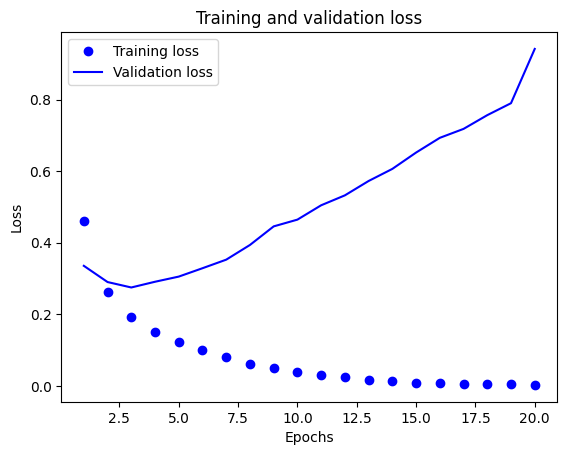

In [15]:
import matplotlib.pyplot as plt

# Training and validation loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")  # 'bo' is for 'blue dot'
plt.plot(epochs, val_loss_values, "b", label="Validation loss")  # 'b' is for 'solid blue line'
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

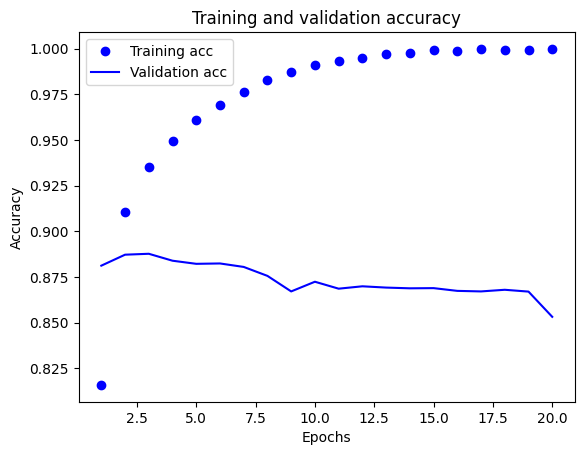

In [16]:
plt.clf()  # clears the figure

# Training and validation accuracy
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Retraining a model from scratch
As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That’s what you would expect when running gradient-descent optimization the quantity you’re trying to minimize should be less with every iteration.

But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. In precise terms, what we ’re seeing is **overfitting**: after the fourth epoch, we’re overoptimizing on the training data, ending up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

In this case, to prevent overfitting, we could stop training after four epochs. In
general, you can use a range of techniques to mitigate overfitting, which will be covered in the next notebooks.

For now let’s train a new model from scratch for four epochs and then evaluate it on the
test data.

In [17]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7173 - loss: 0.5857
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8959 - loss: 0.2999
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9221 - loss: 0.2209
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9367 - loss: 0.1825
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8781 - loss: 0.3001


In [18]:
results

[0.30053332448005676, 0.8796799778938293]

## Using a trained model to generate predictions on new data
After having trained a model, you’ll want to use it in a practical setting. You can generate the likelihood of reviews being positive by using the ```predict``` method:

In [19]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.16352999],
       [0.99931836],
       [0.6045898 ],
       ...,
       [0.07054751],
       [0.04867341],
       [0.40782678]], dtype=float32)